In [1]:
!where python

c:\Users\HK-Laptop-V639\Documents\GitHub\696\env696\Scripts\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Programs\Python\Python312\python.exe
C:\Users\HK-Laptop-V639\AppData\Local\Microsoft\WindowsApps\python.exe


In [2]:
import pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
# fix random state
RANDOM_SEED = 123

import torch
import random
import os
os.environ["OMP_NUM_THREADS"] = "1"
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)
    torch.cuda.manual_seed_all(RANDOM_SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
# import necessary assets
import joblib

train_dl = joblib.load('assets/train_deep_learning_with_theme.joblib')
test_dl = joblib.load('assets/test_deep_learning_with_theme.joblib')

In [5]:
train_dl.sample(5)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned
14757,Argate Online,manga,6.41,1315,currently_publishing,NaN,NaN,4493,5,True,"[Action, Adventure, Fantasy]",[],[],"[Rei, Tsumugu Touno]",[AlphaPolis Web Manga],"Izu Takashi was just playing the online game ""...",Argate Online,アルゲートオンライン,False,2017.0,NaN,Summer,NaN,0.333815,Fantasy Adventure / Isekai (alternate world)
9542,Demi-chan wa Kataritai,manga,7.75,6130,finished,78.0,NaN,24171,268,True,"[Comedy, Fantasy]",[School],[Seinen],[Petosu],[Young Magazine (Monthly)],"Succubus, Dullahan and Vampire. They are known...",Interviews with Monster Girls,亜人〈デミ〉ちゃんは語りたい,False,2014.0,2022.0,Summer,Autumn,0.000706,High School Life and Romance
12400,Tadareta Koi ni wa Itashimasen!,manga,6.99,1229,finished,6.0,NaN,2352,5,False,"[Boys Love, Comedy, Erotica]",[],[],[Shouko Rakuta],[LiQulle],"On his first day living alone in Tokyo, Kyouhe...",I'm Looking for Serious Love!,ただれた恋にはいたしません!,False,2018.0,2019.0,Summer,Winter,0.017270,High School Life and Romance
11375,Mayonaka Love Alliance,manga,7.23,1411,finished,6.0,NaN,2986,11,False,"[Boys Love, Erotica]",[],[],[Atami Michinoku],[Qpa],1-2. Otoshiana ni Hamerarete\r\n3-4. Pinup Boy...,The Love Alliance in Midnight,真夜中ラブアライアンス,False,2016.0,2016.0,Winter,Autumn,0.002446,Romance with sensitive content
7637,Nandaku Mou,music,5.28,123,finished_airing,1.0,music,262,0,True,[],[Music],[],[Onionskin],[Hipland Music Corporation],"A music video for Kidori Kidori's song ""Nandak...",Nandaku-mou,なんだかもう,True,2015.0,2015.0,Spring,Spring,0.005932,"Music, Bands, and Performances"


In [6]:
train_dl.shape

(19453, 25)

In [7]:
train_dl_score = train_dl.dropna(subset='score').copy()
train_dl_score.shape

(13484, 25)

In [8]:
train_dl_popularity = train_dl.dropna(subset='members').copy()
train_dl_popularity.shape

(19453, 25)

In [9]:
test_dl_score = test_dl.dropna(subset='score').copy()
test_dl_popularity = test_dl.dropna(subset='members').copy()

In [10]:
import matplotlib.pyplot as plt

def outliers_evaluation(target, threshold = 3):
    df = train_dl_score if target == 'score' else train_dl_popularity

    mean = np.mean(df[target])
    std = np.std(df[target])

    outliers = np.abs(df[target] - mean) > threshold * std
    num_outliers = np.sum(outliers)

    print(f"Number of outliers: {num_outliers} ")
    print(f"proportion: {num_outliers / len(df[target])}")

    # Boxplot to visually identify outliers
    plt.boxplot(df[target])
    plt.title("Boxplot of Target Variable")
    plt.show()

Number of outliers: 92 
proportion: 0.006822901216256304


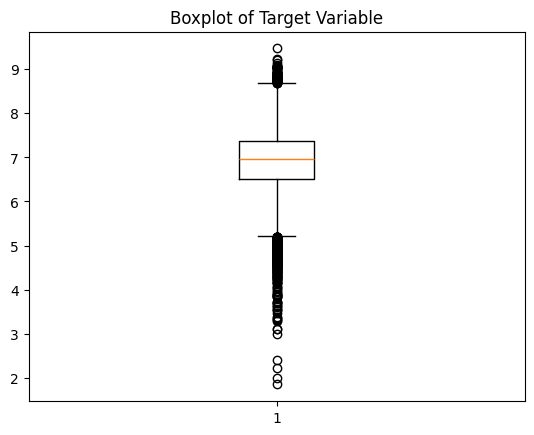

In [11]:
outliers_evaluation('score')

Number of outliers: 320 
proportion: 0.016449904898987303


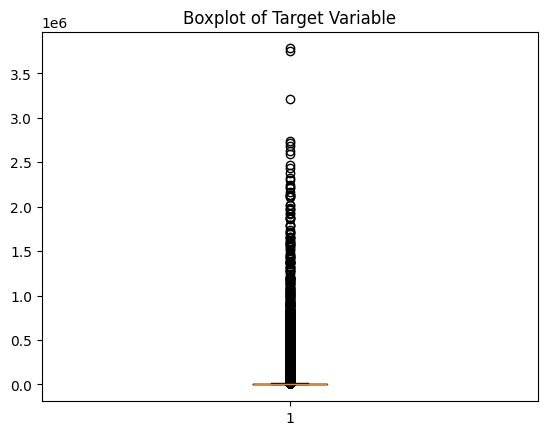

In [12]:
outliers_evaluation('members')

# Score prediction

In [13]:
single_cat_columns = ['type', 'status', 'source', 'start_season', 'end_season', 'theme_assigned']
multi_cat_columns = ['genres', 'demographics', 'creators', 'production_source', 'themes']
numeric_columns = ['score', 'scored_by', 'episodes/chapters', 'members', 'favorites', 'start_year', 'end_year', 'topic_BERTopic_score']
boolean_columns = ['sfw', 'is_anime']

## Pre-processing

1. Handle Missing Values for Single Categorical Columns: Fill with 'Missing'.
2. Label Encode Single Categorical and Multi-Categorical Columns.
3. Pad Multi-Categorical Columns with 0 after label encoding.
4. Use KNN Imputation for numerical columns using all categorical and boolean columns as features for imputation.
5. Standardize the imputed numerical columns.
6. Pass through PyTorch model with embeddings for categorical features and dense layers for numerical features.

In [30]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence

# Step 1: Handle Missing Values in Single Categorical Columns
for col in single_cat_columns:
    train_dl_score[col] = train_dl_score[col].fillna('Missing')

# Step 2: Label Encode Single Categorical Columns
single_cat_label_encoders = {}
for col in single_cat_columns:
    all_categories = train_dl_score[col].unique().tolist()
    all_categories.append("Unknown")  # Add "Unknown" for unseen category in test set

    # Fit the LabelEncoder with the extended list of categories
    le = LabelEncoder().fit(all_categories)
    single_cat_label_encoders[col] = le
    train_dl_score[col + '_encoded'] = le.transform(train_dl_score[col])

# Step 3: Label Encode and Pad Multi-Categorical Columns
multi_cat_label_encoders = {}
for col in multi_cat_columns:
    all_categories = set(item for sublist in train_dl_score[col] for item in sublist)  # Set of unique categories
    all_categories.add("Unknown")  # Add "Unknown" for unseen category in test set

    le = LabelEncoder().fit(list(all_categories))

    # Label encode each element in the list
    train_dl_score[col + '_encoded'] = train_dl_score[col].apply(lambda x: le.transform(x).tolist())
    multi_cat_label_encoders[col] = le
    
    # Pad sequences with 0 (padding index)
    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in train_dl_score[col + '_encoded']],
        batch_first=True, padding_value=0
    )
    
    # Convert padded sequences into a list of tensors (1D arrays)
    train_dl_score[col + '_encoded_padded'] = list(padded_sequences.numpy())

In [15]:
train_dl_score.sample(3)

,title,type,score,scored_by,status,episodes/chapters,source,members,favorites,sfw,genres,themes,demographics,creators,production_source,synopsis,title_english,title_japanese,is_anime,start_year,end_year,start_season,end_season,topic_BERTopic_score,theme_assigned,type_encoded,status_encoded,source_encoded,start_season_encoded,end_season_encoded,theme_assigned_encoded,genres_encoded,genres_encoded_padded,demographics_encoded,demographics_encoded_padded,creators_encoded,creators_encoded_padded,production_source_encoded,production_source_encoded_padded,themes_encoded,themes_encoded_padded
14455,Summer Solstice Point,manhwa,7.12,235,finished,NaN,Missing,543,4,False,"[Drama, Erotica, Romance]",[],[],[Yuju],[],"""I've never kissed anyone before... so help me...",Summer Solstice Point,하지점,False,2019.0,2020.0,Autumn,Summer,0.717827,"Adult Life, Work, and Relationships",5,3,1,0,3,1,"[6, 8, 15]","[6, 8, 15, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[6584],"[6584, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[],"[0, 0, 0, 0, 0, 0]"
12514,"Kouchuugun Shikan, Boukensha ni Naru",manga,7.03,934,currently_publishing,NaN,Missing,3242,22,True,"[Action, Adventure, Fantasy, Sci-Fi]",[],[],"[Tomomasa Takuma, Atsuhiko Ito]",[Dengeki Comic Regulus],The spaceship which Imperial Galactic Navy Off...,Captain Corinth: The Galactic Navy Officer Bec...,航宙軍士官、冒険者になる,False,2018.0,NaN,Autumn,Missing,0.696713,"Sci-Fi, Space, and Mecha Battles",3,1,1,0,1,8,"[0, 1, 9, 16]","[0, 1, 9, 16, 0, 0, 0, 0, 0, 0]",[],"[0, 0]","[5938, 374]","[5938, 374, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[501],"[501, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[],"[0, 0, 0, 0, 0, 0]"
13502,Dungeon ni Deai wo Motomeru no wa Machigatteir...,manga,6.96,563,finished,35.0,Missing,1973,5,True,"[Action, Comedy, Fantasy]",[],[],[Masaya Takamura],[Gangan Online],4-koma spin-off of the Dungeon ni Deai wo Moto...,Is It Wrong to Try to Pick Up Girls in a Dunge...,ダンジョンに出会いを求めるのは間違っているだろうか4コマ,False,2014.0,2017.0,Summer,Spring,0.018872,Romance with sensitive content,3,3,1,3,2,6,"[0, 5, 9]","[0, 5, 9, 0, 0, 0, 0, 0, 0, 0]",[],"[0, 0]",[3296],"[3296, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",[634],"[634, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0...",[],"[0, 0, 0, 0, 0, 0]"


In [32]:
# Step 4: KNN Imputation for Numerical Columns
# Use all categorical and boolean columns (label-encoded) for imputation
imputation_features = [col + '_encoded' for col in single_cat_columns] + boolean_columns
knn_imputer = KNNImputer(n_neighbors=5)

# Combine categorical, boolean, and numeric columns for imputation
combined_data = np.hstack([train_dl_score[imputation_features].values, train_dl_score[numeric_columns].values])
imputed_data = knn_imputer.fit_transform(combined_data)

# Update the dataframe with imputed numerical values
train_dl_score[numeric_columns] = imputed_data[:, -len(numeric_columns):]

# Step 5: Standardize the Imputed Numerical Columns
scaler = StandardScaler()
train_dl_score[numeric_columns] = scaler.fit_transform(train_dl_score[numeric_columns])

In [17]:
train_dl_score.isnull().sum()

title                               0
type                                0
score                               0
scored_by                           0
status                              0
episodes/chapters                   0
source                              0
members                             0
favorites                           0
sfw                                 0
genres                              0
themes                              0
demographics                        0
creators                            0
production_source                   0
synopsis                            0
title_english                       0
title_japanese                      0
is_anime                            0
start_year                          0
end_year                            0
start_season                        0
end_season                          0
topic_BERTopic_score                0
theme_assigned                      0
type_encoded                        0
status_encod

In [18]:
numeric_columns.remove('score')

### Apply same transformation on test set

In [33]:
# Step 1: Handle Missing Values in Single Categorical Columns
for col in single_cat_columns:
    test_dl_score[col] = test_dl_score[col].fillna('Missing')

# Step 2: Label Encode Single Categorical Columns
for col in single_cat_columns:
    le = single_cat_label_encoders[col]  # Use the pre-fitted label encoder
    test_dl_score[col + '_encoded'] = test_dl_score[col].apply(
        lambda x: le.transform([x])[0] if x in le.classes_ else le.transform(["Unknown"])[0]
    )

# Step 3: Label Encode and Pad Multi-Categorical Columns for Test Set
for col in multi_cat_columns:
    le = multi_cat_label_encoders[col]  # Use the pre-fitted label encoder
    
    # Custom transformation: Handle unseen categories by mapping them to "Unknown"
    test_dl_score[col + '_encoded'] = test_dl_score[col].apply(
        lambda x: [le.transform([item])[0] if item in le.classes_ else le.transform(["Unknown"])[0] for item in x]
    )
    
    # Pad sequences with 0 (padding index)
    padded_sequences = pad_sequence(
        [torch.tensor(row, dtype=torch.int64) for row in test_dl_score[col + '_encoded']],
        batch_first=True, padding_value=0
    )
    
    # Convert padded sequences into a list of tensors (1D arrays)
    test_dl_score[col + '_encoded_padded'] = list(padded_sequences.numpy())

# Step 4: KNN Imputation for Numerical Columns
combined_data = np.hstack([test_dl_score[imputation_features].values, test_dl_score[numeric_columns].values])
imputed_data = knn_imputer.transform(combined_data)
test_dl_score[numeric_columns] = imputed_data[:, -len(numeric_columns):]

# Step 5: Standardize the Imputed Numerical Columns
test_dl_score[numeric_columns] = scaler.transform(test_dl_score[numeric_columns])

## Prepare PyTorch Dataset

In [19]:
from torch.utils.data import Dataset

class AnimeMangaDataset(Dataset):
    def __init__(self, single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores):
        self.single_cat_inputs = single_cat_inputs
        self.multi_cat_inputs = multi_cat_inputs
        self.numeric_inputs = numeric_inputs
        self.boolean_inputs = boolean_inputs
        self.target_scores = target_scores

    def __len__(self):
        return len(self.target_scores)

    def __getitem__(self, idx):
        # For each sample, return the inputs and the corresponding target (score)
        single_cat_input = self.single_cat_inputs[idx]
        multi_cat_input = [multi_cat[idx] for multi_cat in self.multi_cat_inputs]  # Extract each multi-cat feature
        numeric_input = self.numeric_inputs[idx]
        boolean_input = self.boolean_inputs[idx]
        target = self.target_scores[idx]
        
        return single_cat_input, multi_cat_input, numeric_input, boolean_input, target
    
# Convert the target score into a tensor
target_scores = torch.tensor(train_dl_score['score'].values, dtype=torch.float32)

# Convert ALL single categorical columns into a tensor
single_cat_inputs = torch.tensor(train_dl_score[[col + '_encoded' for col in single_cat_columns]].values)

# Convert EACH multiple categorical column into a tensor
multi_cat_inputs = [
    torch.tensor(np.stack(train_dl_score[col + '_encoded_padded'].values), dtype=torch.int64)
    for col in multi_cat_columns
]

# Convert ALL numerical columns into a tensor
numeric_inputs = torch.tensor(train_dl_score[numeric_columns].values, dtype=torch.float32)

# Convert ALL boolean columns into a tensor
boolean_inputs = torch.tensor(train_dl_score[boolean_columns].values)

# Create an instance of the custom dataset
dataset = AnimeMangaDataset(single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs, target_scores)

## Prepare Model

In [20]:
class AnimeMangaModel(nn.Module):
    def __init__(self, single_cat_dims, multi_cat_dims, embedding_dim, num_numeric, num_boolean, hidden_sizes, dropout_rate):
        super(AnimeMangaModel, self).__init__()

        # Embedding layers for single categorical columns
        self.single_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim) for cat_dim in single_cat_dims
        ])

        # Embedding layers for multi-categorical columns with padding
        self.multi_cat_embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim, padding_idx=0) for cat_dim in multi_cat_dims
        ])

        # Dense layer for numeric and boolean inputs
        self.numeric_dense = nn.Linear(num_numeric, embedding_dim)
        self.boolean_dense = nn.Linear(num_boolean, embedding_dim)

        # Fully connected layers
        self.fc_layers = nn.ModuleList()
        self.dropout = nn.Dropout(dropout_rate)
        input_size = embedding_dim * (len(single_cat_dims) + len(multi_cat_dims) + 2)
        for hidden_size in hidden_sizes:
            self.fc_layers.append(nn.Linear(input_size, hidden_size))
            input_size = hidden_size
        self.output = nn.Linear(input_size, 1)  # Output for regression

    def forward(self, single_cat_inputs, multi_cat_inputs, numeric_inputs, boolean_inputs):
        # Process single categorical columns through embeddings
        single_cat_embeds = [
            embed(single_cat_inputs[:, i]) for i, embed in enumerate(self.single_cat_embeddings)
        ]
        
        # Process multi-categorical columns through embeddings with padding
        multi_cat_embeds = [
            torch.mean(embed(multi_cat_inputs[i]), dim=1) for i, embed in enumerate(self.multi_cat_embeddings)
        ]

        # Process numeric and boolean features through dense layers
        numeric_out = torch.relu(self.numeric_dense(numeric_inputs))
        boolean_out = torch.relu(self.boolean_dense(boolean_inputs.float()))

        # Concatenate all features together
        combined = torch.cat(single_cat_embeds + multi_cat_embeds + [numeric_out, boolean_out], dim=1)

        # Pass through fully connected layers
        x = combined
        for fc_layer in self.fc_layers:
            x = torch.relu(fc_layer(x))
            x = self.dropout(x)
        output = self.output(x)  # Regression output
        
        return output
    
# Dimensions for embedding layers
single_cat_dims = [train_dl_score[col + '_encoded'].nunique() for col in single_cat_columns]
multi_cat_dims = [train_dl_score[col + '_encoded_padded'].apply(lambda x: max(x)).max() + 1 for col in multi_cat_columns]

## Training Loop (with cross validation)

In [21]:
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from sklearn.model_selection import KFold
import optuna

K_FOLDS = 5
NUM_EPOCHS = 5
PATIENCE = 3
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set up Optuna's logging system
optuna.logging.set_verbosity(optuna.logging.INFO)

def objective(trial):
    # Hyperparameter suggestions by Optuna
    embedding_dim = trial.suggest_int('embedding_dim', 4, 16)
    num_layers = trial.suggest_int('num_layers', 2, 5)
    hidden_sizes = [trial.suggest_int(f'hidden_size_{i}', 16, 128) for i in range(num_layers)]
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # K-Fold Cross Validation
    kf = KFold(n_splits=K_FOLDS, shuffle=True, random_state=RANDOM_SEED)
    targets = train_dl_score['score'].values
    fold_results = []

    # To store the trail loss
    trial_training_loss = []
    trial_validation_loss = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(np.arange(len(targets)))):
        # Create Subsets and DataLoader for the current fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, generator=torch.Generator().manual_seed(RANDOM_SEED))
        val_loader = DataLoader(val_subset, batch_size=batch_size * 2, shuffle=False)

        # Initialize model for each fold
        model = AnimeMangaModel(
            single_cat_dims=single_cat_dims,
            multi_cat_dims=multi_cat_dims,
            embedding_dim=embedding_dim,
            num_numeric=len(numeric_columns),
            num_boolean=len(boolean_columns),
            hidden_sizes=hidden_sizes,
            dropout_rate=dropout_rate
        ).to(device)

        # Define optimizer and loss function
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Initialization for each fold
        best_val_loss = float('inf')
        epochs_no_improve = 0
        best_model_state = None
        fold_train_loss = []
        fold_val_loss = []

        # Training loop with early stopping
        for epoch in range(NUM_EPOCHS):
            model.train()
            train_loss = 0
            for batch in train_loader:
                single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch, target_batch = batch
                single_cat_batch = single_cat_batch.to(device)
                multi_cat_batch = [tensor.to(device) for tensor in multi_cat_batch]
                numeric_batch = numeric_batch.to(device)
                boolean_batch = boolean_batch.to(device)
                target_batch = target_batch.to(device)

                optimizer.zero_grad() # Zero the parameter gradients
                output = model(single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch) # Forward pass
                loss = criterion(output.squeeze(), target_batch) # Compute loss
                loss.backward() # Backward pass
                optimizer.step() # Optimization
                train_loss += loss.item() # Accumulate training loss

            train_loss /= len(train_loader) # Average train loss for this fold
            fold_train_loss.append(train_loss)

            # Validation loop
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for batch in val_loader:
                    single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch, target_batch = batch
                    single_cat_batch = single_cat_batch.to(device)
                    multi_cat_batch = [tensor.to(device) for tensor in multi_cat_batch]
                    numeric_batch = numeric_batch.to(device)
                    boolean_batch = boolean_batch.to(device)
                    target_batch = target_batch.to(device)

                    output = model(single_cat_batch, multi_cat_batch, numeric_batch, boolean_batch) # Forward pass
                    loss = criterion(output.squeeze(), target_batch) # Compute loss
                    val_loss += loss.item() # Accumulate validation loss

            val_loss /= len(val_loader) # Average validation loss for this fold
            fold_val_loss.append(val_loss)

            # Early stopping check
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict() # Save best model state
            else:
                epochs_no_improve += 1

            if epochs_no_improve >= PATIENCE:
                break

        fold_results.append(best_val_loss)
        trial_training_loss.append(fold_train_loss)
        trial_validation_loss.append(fold_val_loss)

    # Average validation loss across all folds
    average_val_loss = np.mean(fold_results)

    # Save the best model state
    trial.set_user_attr("best_model_state", best_model_state)

    # Save metrics for later plotting
    trial.set_user_attr('training_loss', trial_training_loss)
    trial.set_user_attr('validation_loss', trial_validation_loss)

    return average_val_loss

# Create a study and optimize
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

# Reconstruct the best model
best_trial = study.best_trial
best_model_state = best_trial.user_attrs["best_model_state"]
embedding_dim = best_trial.params['embedding_dim']
num_layers = best_trial.params['num_layers']
hidden_sizes = [best_trial.params[f'hidden_size_{i}'] for i in range(num_layers)]
dropout_rate = best_trial.params['dropout_rate']

best_model = AnimeMangaModel(
    single_cat_dims=single_cat_dims,
    multi_cat_dims=multi_cat_dims,
    embedding_dim=embedding_dim,
    num_numeric=len(numeric_columns),
    num_boolean=len(boolean_columns),
    hidden_sizes=hidden_sizes,
    dropout_rate=dropout_rate
).to(device)

best_model.load_state_dict(best_model_state)

# Print the best result
print('Best trial:')
print(f'  MSE: {best_trial.value}')
print(f'  RMSE: {np.sqrt(best_trial.value)}')
print('  Params: ')
for key, value in best_trial.params.items():
    print(f'    {key}: {value}')

[I 2024-10-18 17:48:50,576] A new study created in memory with name: no-name-49ac5dfa-32c1-481a-9fae-9a29263669f5
[I 2024-10-18 17:49:19,474] Trial 0 finished with value: 0.38956004733389077 and parameters: {'embedding_dim': 16, 'num_layers': 3, 'hidden_size_0': 111, 'hidden_size_1': 46, 'hidden_size_2': 78, 'learning_rate': 0.004571766481369699, 'batch_size': 64, 'dropout_rate': 0.32783065926168076}. Best is trial 0 with value: 0.38956004733389077.
[I 2024-10-18 17:50:04,269] Trial 1 finished with value: 0.40947994111582287 and parameters: {'embedding_dim': 5, 'num_layers': 4, 'hidden_size_0': 90, 'hidden_size_1': 79, 'hidden_size_2': 40, 'hidden_size_3': 41, 'learning_rate': 0.009388039164574633, 'batch_size': 32, 'dropout_rate': 0.23363691241368062}. Best is trial 0 with value: 0.38956004733389077.
[I 2024-10-18 17:51:27,694] Trial 2 finished with value: 0.404363091062097 and parameters: {'embedding_dim': 10, 'num_layers': 3, 'hidden_size_0': 121, 'hidden_size_1': 116, 'hidden_size_

Best trial:
  MSE: 0.3703889676115729
  RMSE: 0.6085958984511586
  Params: 
    embedding_dim: 11
    num_layers: 2
    hidden_size_0: 53
    hidden_size_1: 108
    learning_rate: 0.007871061469626893
    batch_size: 64
    dropout_rate: 0.12449969440768238


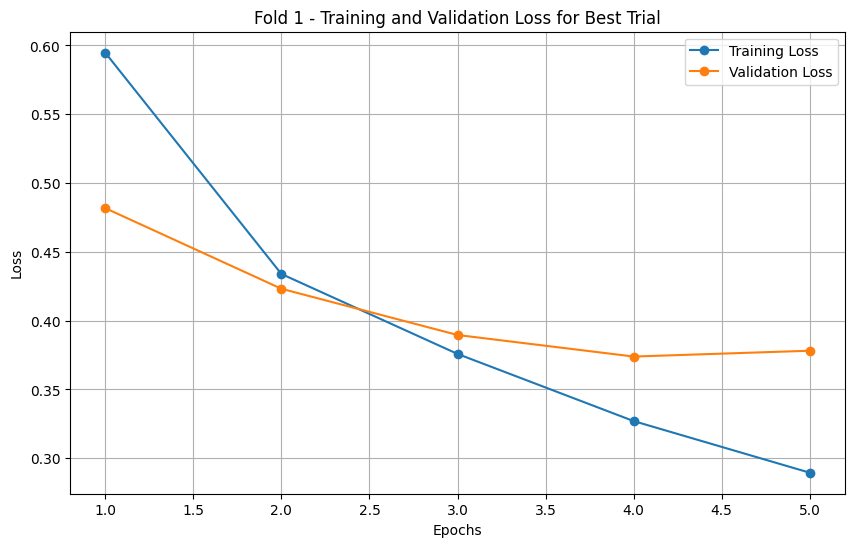

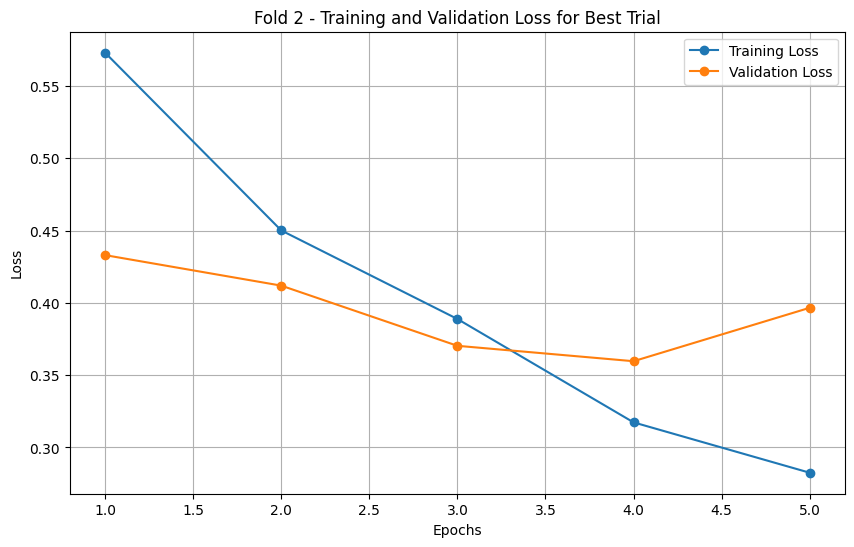

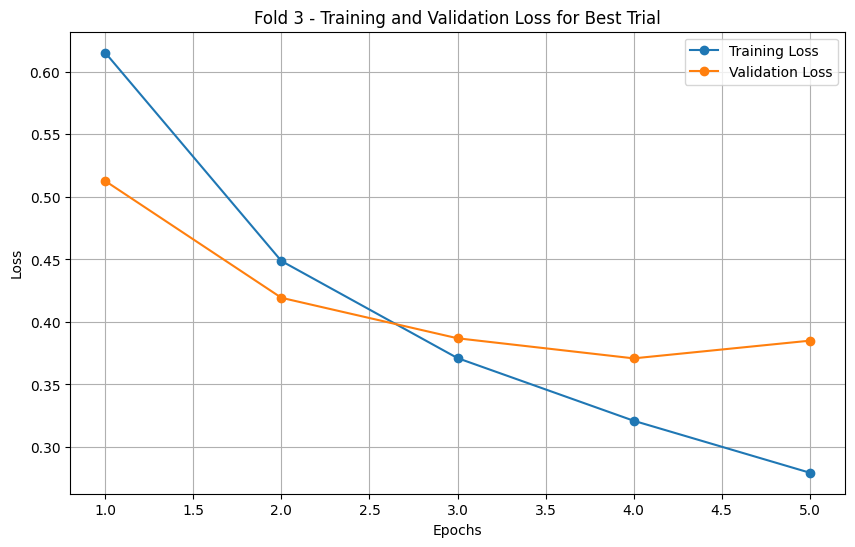

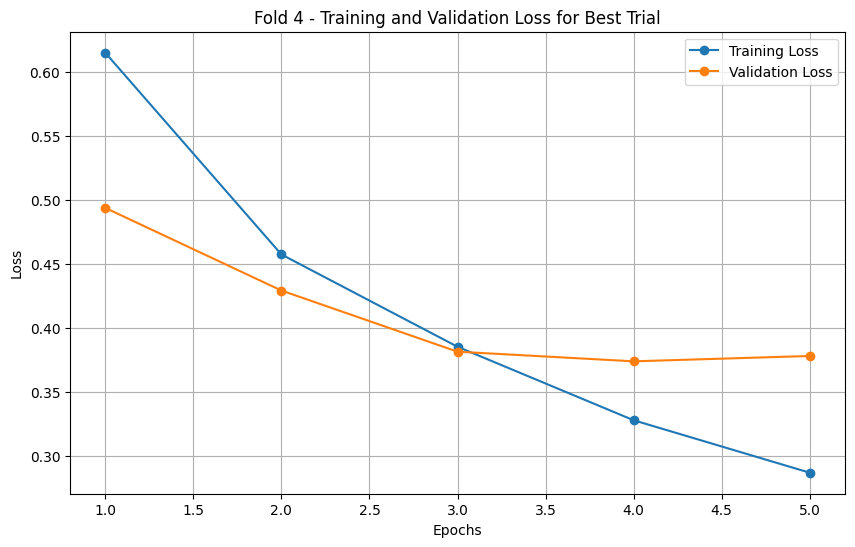

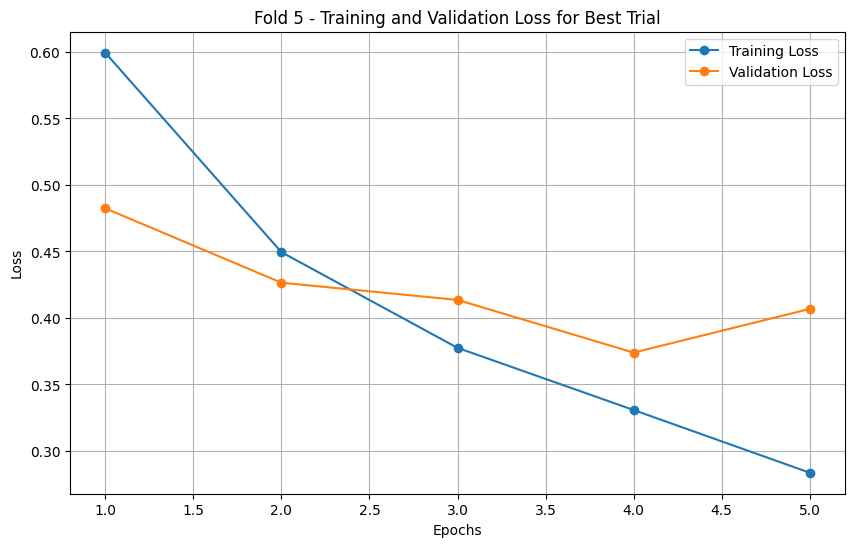

In [22]:
import matplotlib.pyplot as plt

best_training_loss = best_trial.user_attrs['training_loss']
best_validation_loss = best_trial.user_attrs['validation_loss']

# Plot training and validation loss for each fold of the best trial
for fold_idx, (train_loss, val_loss) in enumerate(zip(best_training_loss, best_validation_loss)):
    plt.figure(figsize=(10, 6))
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, label='Training Loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Fold {fold_idx + 1} - Training and Validation Loss for Best Trial')
    plt.legend()
    plt.grid()
    plt.show()

In [23]:
from optuna.visualization import (
    plot_optimization_history,
    plot_param_importances,
    plot_parallel_coordinate,
    plot_slice,
    plot_contour,
    plot_edf
)

# Optimization History
plot_optimization_history(study).show()

In [24]:
# Hyperparameter Importances
plot_param_importances(study).show()

In [25]:
# Parallel Coordinate
plot_parallel_coordinate(study).show()

In [26]:
# Slice Plot
plot_slice(study).show()

In [27]:
# Contour Plot
plot_contour(study).show()

In [28]:
# Plot EDF (Empirical Distribution Function)
plot_edf(study).show()

In [29]:
"""from captum.attr import IntegratedGradients
import torch

# Assuming `best_model` is already trained and available
best_model.eval()  # Set to evaluation mode

# Prepare inputs
inputs = torch.tensor(train_dl_score.values, dtype=torch.float32).to(device)

# Initialize Integrated Gradients
ig = IntegratedGradients(best_model)

# Compute attributions (feature importances)
attributions, delta = ig.attribute(inputs, target=0, return_convergence_delta=True)

# Visualize the feature attributions
plt.figure(figsize=(10, 5))
plt.bar(range(inputs.shape[1]), attributions[0].cpu().detach().numpy())
plt.xlabel('Feature Index')
plt.ylabel('Attribution Score')
plt.title('Feature Importance using Integrated Gradients')
plt.show()"""

TypeError: can't convert np.ndarray of type numpy.object_. The only supported types are: float64, float32, float16, complex64, complex128, int64, int32, int16, int8, uint64, uint32, uint16, uint8, and bool.

In [31]:
# store library version
# run every time before you commit
!pip freeze > requirements.txt